In this notebook, I will work on part 2 of the image stitching series. Between this post and the [previous post](http://learningjulia.com/2017/03/26/image-stitching-part-1.html), I go through all 5 steps of an image stitching pipeline:

1. Extracting feature points (_Part 1_)
2. Calculate descriptors (_Part 1_)
3. Match points (_Part 1_)
4. Calculate transformation (_Part 2_)
5. Stitch images (_Part 2_)

In this notebook, I'll go through Part 2: calculating a transformation and actually stitching the images together.

In [1]:
using ImageFeatures, Images, FileIO, ImageDraw;

I'll use the same two images I used in the previous post, two images of the Stata Center in Cambridge, MA.

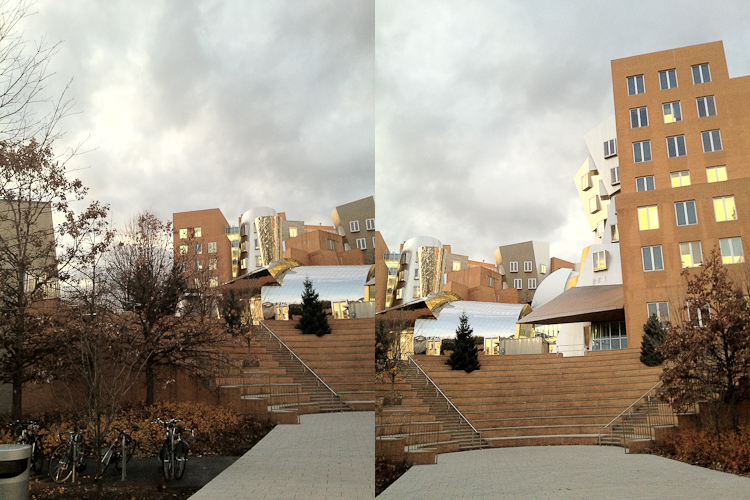

In [2]:
img1 = load("imgs/stata-1.png")
img2 = load("imgs/stata-2.png")
[img1 img2]

To recap steps 1 through 3 from the previous post, we extracted feature points, calculated feature descriptors, and matched the points together.

In [3]:
function get_descriptors(img::AbstractArray)
    brisk_params = BRISK();
    features = Features(Keypoints(imcorner(img, method=harris)));
    desc, ret_features = create_descriptor(Gray.(img), features, brisk_params);
end

function match_points(img1::AbstractArray, img2::AbstractArray, threshold::Float64=0.1)
    desc_1, ret_features_1 = get_descriptors(img1);
    desc_2, ret_features_2 = get_descriptors(img2);
    matches = match_keypoints(Keypoints(ret_features_1), Keypoints(ret_features_2), desc_1, desc_2, threshold);
    return matches;
end

function draw_matches(img1, img2, matches)
    grid = [img1 img2];
    offset = CartesianIndex(0, size(img1, 2));
    for m in matches
        draw!(grid, LineSegment(m[1], m[2] + offset))
    end
    grid
end

draw_matches (generic function with 1 method)

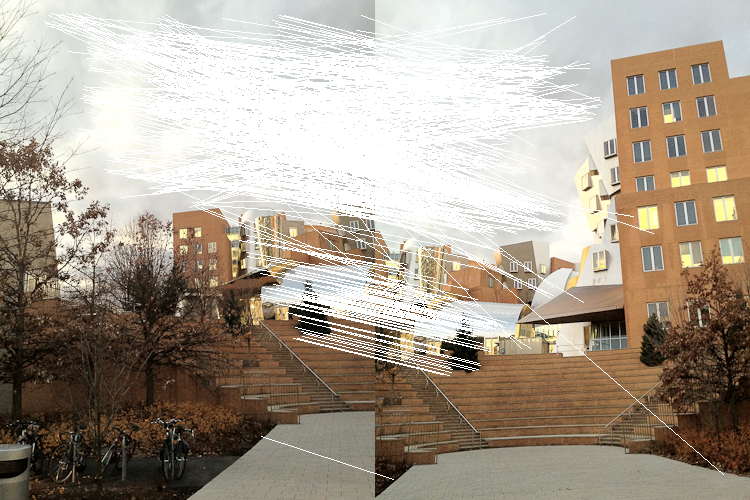

In [4]:
matches = match_points(img1, img2, 0.1);
draw_matches(img1, img2, matches)

# Calculate transformation

Now that we've found the pairs of pixels that correspond between the two images, we can use those matches to find a matrix that describes the transformation from one image to another. We can then use this transformation to warp one of the images and do the stitching.

To calculate the transformation from one image to another, we compute a transformation called a **`homography`**. INSERT EXPLANATION OF HOMOGRAPHY

A homography matrix has 8 free parameters - this means that with 4 pairs of matched points in our image, we can compute a homography that describes how to transform from the first set to the second set of points.

The [ImageProjectiveGeometry](https://github.com/peterkovesi/ImageProjectiveGeometry.jl) package implements a homography filling algorithm, but the package was built for Julia 0.4 and I had a hard time getting to play nice with my Julia 0.6 environment. Instead, I am going to write my own code for this in Julia.

My homography function is going to take some `matches` returned from our descriptor matching function; as a reminder, `matches` is returned as an array of `Keypoints`.

In [122]:
Pkg.add("CoordinateTransformations");

INFO: No packages to install, update or remove
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of CoordinateTransformations
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [133]:
using CoordinateTransformations, StaticArrays;

In [143]:
function compute_homography(matches::Array{Keypoints})
    # eigenvector of A^T A with the smallest eigenvalue
    
    # construct A matrix
    A = @MMatrix zeros(2 * length(matches), 9);
    for (index, match) in enumerate(matches)
        base_index_x = index * 2 - 1;
        base_index_y = 1:3;
        A[base_index_x, base_index_y] = float([match[1][1]; match[1][2]; 1;]);
        A[base_index_x, 7:9] = A[base_index_x, base_index_y] * match[2][1];
        A[base_index_x + 1, 4:6] = A[base_index_x, base_index_y];
        A[base_index_x + 1, 7:9] = A[base_index_x, base_index_y] * match[2][2];
    end
    
    # find the smallest eigenvector, normalize, and reshape
    U, S, V = svd(A);
#     H = V[:, end] ./ V[:, end][end];
#     reshape(H, (3, 3));
    PerspectiveMap(V[:, end])
end

compute_homography (generic function with 2 methods)

The resulting `H` is a homography matrix `H`, or the transformation to apply to the first image to project that image into the space of the second image. Let's use all the matches we got and see what happens:

In [ ]:
H = compute_homography(matches)

## Transform image

Now that we have the homography (transformation) matrix, we need to apply the homography to each pixel in the first image. This will assign a new location to each pixel, effectively warping the original image into the same "space" as the second image.

In [121]:
warp(img1, H)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] warp_old(::Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}, ::Array{Float64,2}) at /home/mprat/.julia/v0.6/ImageTransformations/src/warp.jl:124
 [3] include_string(::String, ::String) at ./loading.jl:515
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mprat/.julia/v0.6/IJulia/src/execute_request.jl:160
 [5] eventloop(::ZMQ.Socket) at /home/mprat/.julia/v0.6/IJulia/src/eventloop.jl:8
 [6] (::IJulia.##11#14)() at ./task.jl:335
while loading In[121], in expression starting on line 1


LoadError: [91mMethodError: objects of type Array{Float64,2} are not callable
Use square brackets [] for indexing an Array.[39m

In [32]:
?warp

search: warp warpedview WarpedView invwarpedview InvWarpedView code_warntype



```
warp(img, tform, [indices], [degree = Linear()], [fill = NaN])
```

`warp` is transitioning to a different interpretation of the transformation, and you are using the old version.

More specifically, this method with the signature `warp(img, tform, args...)` is deprecated in favour of the new interpretation, which is equivalent to calling `warp(img, inv(tform), args...)` right now.

To change to the new behaviour, set `const warp = ImageTransformations.warp_new` right after package import.


# Stitch images

## RANSAC: improving homography estimation

### Aside: environment setup

When trying to install the `ImageProjectiveGeometry` package, I ran into an issue with `PyPlot` and `PyCall`, which definitely contributed to me giving up on it.

One of the dependencies of `ImageProjectiveGeometry` is `PyPlot`, which has a dependency on `PyCall` because `PyPlot` calls `matplotlib` functions from Python. This is slightly messy - now your Julia installation has a dependency on a Python installation on your system! Python has a fantastic system for managing separate installations of packages, called virtual environments. As a long-time Python user, I have a system on my computer with lots of virtual environments with different package versions. I definitely don't want to mix those two.

So how do you get around this problem, given that `ImageProjectiveGeometry` depends on Python's `matplotlib`? Turns out, before installing `ImageProjectiveGeometry`, I added this line:

```
ENV["PYTHON"] = ""
```

before adding the `ImageProjectiveGeometry` package. What this does is lets the `Conda.jl` package install a version of Python specifically for use in the Julia environment you are using.

### Aside: removing deprecation warnings

Another problem with the 

The `ransacfithomography` function emits lots of warnings... this likely means `ImageProjectiveGeometry` hasn't been updated in a while. In my next post, I will explore how I go about submitting a pull request on Github to get rid of these warnings.

But for now, I wanted to suppress deprecation warnings in Jupyter. I followed the helpful instructions in [this Github issue](https://github.com/JuliaLang/IJulia.jl/issues/448#issuecomment-239692191) to add an argument to the Jupyter kernel running my notebook, and voila!

I need to remember to turn off this feature for the next notebook...

There is no way to suppress ALL warnings in Jupyter in the general sense. In fact, there is a [Github issue](https://github.com/JuliaLang/IJulia.jl/issues/116) about it on the IJulia package, with much follow-up discussion.